In [1]:
import pandas as pd
import scipy.sparse as sparse
import numpy as np
from tqdm import tqdm

import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

seed =45
%matplotlib inline
plt.style.use('fivethirtyeight')
from collections import defaultdict

In [2]:
train_data  = pd.read_csv(r'train.csv')
test_data   = pd.read_csv(r'test.csv')
prod_attr   = pd.read_csv(r'product_attributes.csv')
sample_data = pd.read_csv(r'submission.csv')

In [3]:
train_data.head()

,UserId,productid,Quantity,OrderDate
0,18075,12322648,1,01/04/18
1,6820,12371370,1,01/04/18
2,6820,12973004,1,01/04/18
3,6820,12657560,1,01/04/18
4,6820,11659914,1,01/04/18


In [4]:
test_data.head()

,UserId
0,2
1,28
2,36
3,38
4,41


In [5]:
prod_attr.head()

,productid,attribute_name,attributevalue
0,11145600,Fit,37
1,11145600,Sleeve Length,23
2,11145600,Fabric,16
3,11145600,Color,25
4,11145600,Neckline,51


In [6]:
sample_data.head()

,UserId,product_list
0,2,"[11660064, 12407190, 12657902, 12407058, 12407..."
1,28,"[12407706, 13039778, 12407148, 12407206, 13653..."
2,36,"[12407648, 13650238, 12407790, 12371378, 12407..."
3,38,"[12406972, 12407558, 11147300, 12406974, 12407..."
4,41,"[11659236, 11360904, 11659464, 11460670, 12657..."


### Calculate the number of unique users and products

In [7]:
n_users = train_data.UserId.unique().shape[0]
n_product = train_data.productid.unique().shape[0]


In [8]:
n_users

27778

In [9]:
n_product

3026

### Does all products have all (9) unique product attributes?

In [10]:
prod_attr_check = prod_attr.pivot_table('attributevalue',['productid'],'attribute_name')
prod_attr_check.head(10)

attribute_name,Category,Collection,Color,Fabric,Fit,Material,Neckline,Season,Sleeve Length
productid,,,,,,,,,
11139192,1.0,NaN,41.0,2.0,0.0,NaN,NaN,42.0,NaN
11139194,1.0,NaN,25.0,2.0,0.0,NaN,NaN,42.0,NaN
11139524,1.0,NaN,95.0,16.0,14.0,NaN,4.0,42.0,23.0
11139560,1.0,NaN,41.0,2.0,14.0,NaN,4.0,42.0,127.0
11139588,1.0,NaN,25.0,58.0,0.0,NaN,NaN,42.0,NaN
11139650,1.0,NaN,31.0,2.0,14.0,NaN,4.0,42.0,23.0
11141306,1.0,NaN,28.0,2.0,NaN,NaN,NaN,56.0,NaN
11141308,1.0,NaN,71.0,2.0,0.0,NaN,NaN,56.0,NaN
11141318,1.0,NaN,149.0,2.0,0.0,NaN,NaN,56.0,NaN


In [11]:
prod_attr_check.count()

attribute_name
Category         2968
Collection        229
Color            2982
Fabric           2760
Fit              2351
Material          223
Neckline         2117
Season           2992
Sleeve Length    2121
dtype: int64

Fit


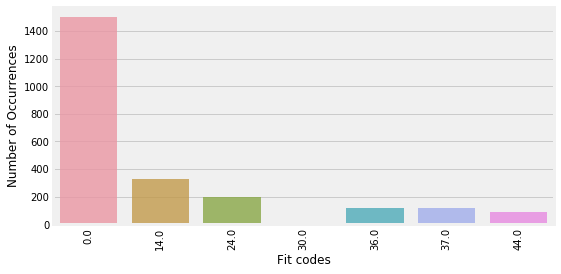

Sleeve Length


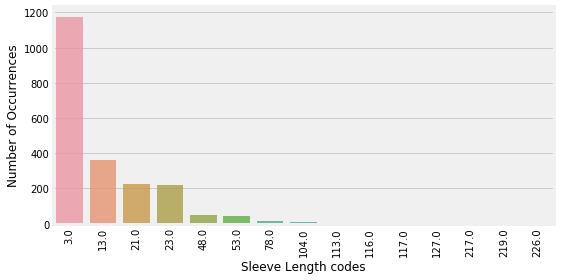

Fabric


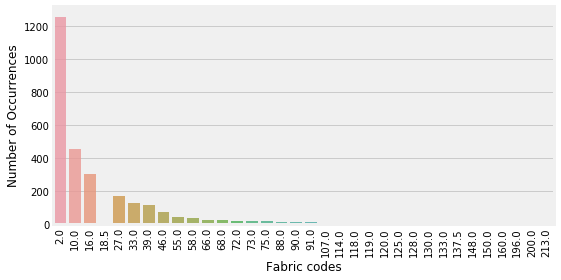

Color


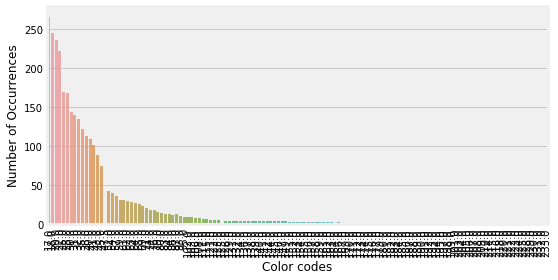

Neckline


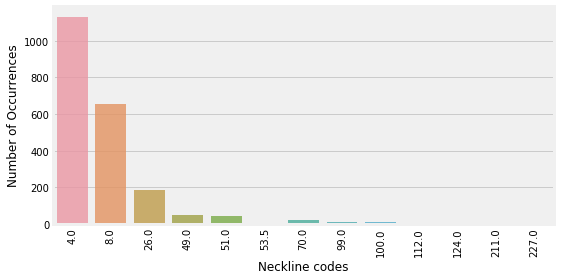

Category


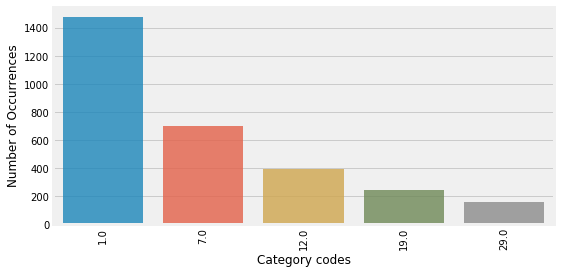

Season


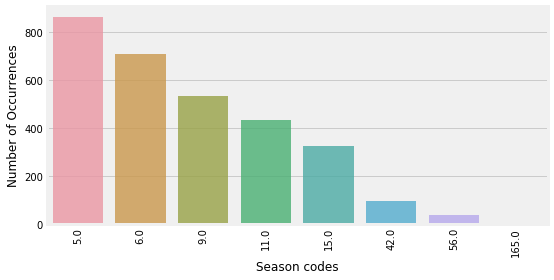

Material


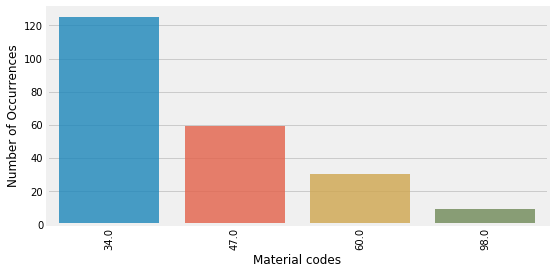

Collection


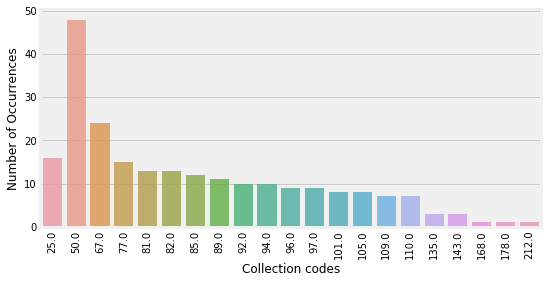

In [12]:
for x in prod_attr.attribute_name.unique():
    print(x)
    cnt_srs = prod_attr_check[x].value_counts()
    plt.figure(figsize=(8,4))
    sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8)
    plt.xticks(rotation='vertical')
    plt.xlabel(str(x+' codes'), fontsize=12)
    plt.ylabel('Number of Occurrences', fontsize=12)
    plt.show()

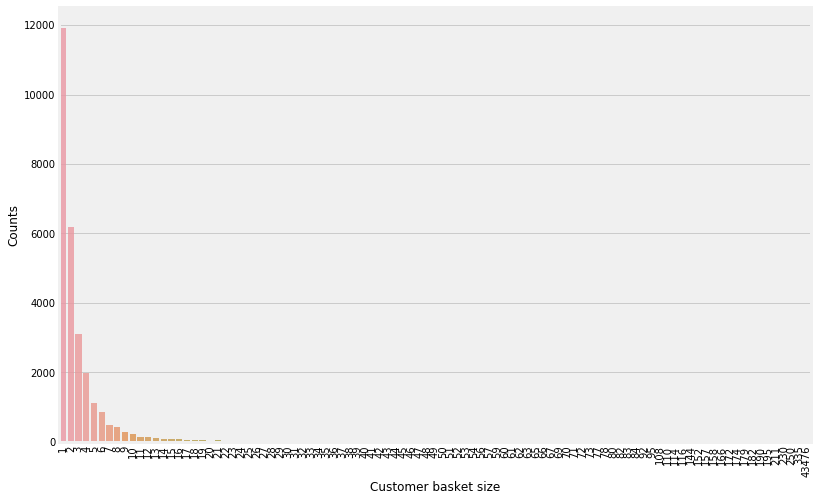

In [13]:
cnt_srs = train_data.groupby("UserId")["Quantity"].aggregate(np.sum).reset_index()
cnt_srs = cnt_srs.Quantity.value_counts()

plt.figure(figsize=(12,8))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8)
plt.ylabel('Counts', fontsize=12)
plt.xlabel('Customer basket size', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

### Are these Customers going for Novelty or buying the same products, lets figure out

In [14]:
train_data_prod_grouping = (train_data.groupby('UserId')['productid'].apply(lambda x: list(x)).reset_index())

In [15]:
train_data_prod_grouping.head()

,UserId,productid
0,0,[11659624]
1,1,[12406904]
2,2,[11660064]
3,3,"[12658228, 12360440, 12407616, 12407522, 12407..."
4,4,"[12437468, 11659934]"


### Lets understand the pattern of buying same product multiple times...

In [16]:
def count_duplicates(seq): 


    return len(seq) - len(set(seq))
count = 0
pcount = 0
duplicate_count = []
product_count = []
for i in range(0,len(train_data_prod_grouping)):
    prod_list = train_data_prod_grouping.productid[i]
    count = count_duplicates(prod_list)
    pcount = len(prod_list)
    if count > 0:
        duplicate_count.append(count)
        product_count.append(pcount)
    train_data_prod_grouping.at[i,'buying_same_product_count'] = count
    train_data_prod_grouping.at[i,'Overall_products_bought']  = pcount

In [17]:
train_data_prod_grouping

,UserId,productid,buying_same_product_count,Overall_products_bought
0,0,[11659624],0.0,1.0
1,1,[12406904],0.0,1.0
2,2,[11660064],0.0,1.0
3,3,"[12658228, 12360440, 12407616, 12407522, 12407...",12.0,18.0
4,4,"[12437468, 11659934]",0.0,2.0
5,5,"[11145740, 12658512]",0.0,2.0
6,6,[13039720],0.0,1.0
7,7,[11659742],0.0,1.0
8,8,"[12947668, 12947668, 12947668, 13039546]",2.0,4.0
9,9,"[12658634, 13039040]",0.0,2.0


In [18]:
test_data_1 = pd.merge(test_data,train_data_prod_grouping[['UserId','buying_same_product_count','Overall_products_bought']],on='UserId', how='left')

In [19]:
train_data['value'] = 1
train_data_fmt = pd.pivot_table(train_data,values="value",index=["UserId"],columns="productid",fill_value=0)
train_data_fmt.head(10)

productid,11139192,11139194,11139524,11139560,11139588,11139650,11141306,11141308,11141318,11141320,...,14122758,14122762,14122766,14122818,14122820,14122822,14122832,14122834,14128359,14129477
UserId,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [20]:
train_matrix = train_data_fmt.as_matrix()

In [21]:
train_matrix

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [22]:
import numpy as np
from lightfm.datasets import fetch_movielens
from lightfm import LightFM
model = LightFM(loss = 'warp')

In [23]:
train_data['bought']  = 1
train_data.head()

,UserId,productid,Quantity,OrderDate,value,bought
0,18075,12322648,1,01/04/18,1,1
1,6820,12371370,1,01/04/18,1,1
2,6820,12973004,1,01/04/18,1,1
3,6820,12657560,1,01/04/18,1,1
4,6820,11659914,1,01/04/18,1,1


In [24]:
from scipy.sparse import coo_matrix
import scipy.sparse as sparse
import scipy
from lightfm import LightFM

In [25]:
df_train = train_data.copy()
df_test = test_data[(test_data['UserId'].isin(df_train['UserId']))]
id_cols=['UserId','productid','bought']

In [26]:
from sklearn import preprocessing
trans_cat_train=dict()
# trans_cat_test=dict()
for k in id_cols:
    cate_enc=preprocessing.LabelEncoder()
    trans_cat_train[k]=cate_enc.fit_transform(df_train[k].values)
#     trans_cat_test[k]=cate_enc.transform(df_test[k].values)

In [27]:
rate_matrix=dict()
rate_matrix['train']=coo_matrix((trans_cat_train['bought'],(trans_cat_train['UserId'],\
                                              trans_cat_train['productid']))\
                             ,shape=(n_users,n_product))

In [28]:
model=LightFM(no_components=5,loss='warp')
model.fit(rate_matrix['train'],epochs=100,num_threads=1)


In [29]:
from sklearn.metrics import roc_auc_score
from lightfm.evaluation import auc_score
auc_train = auc_score(model, rate_matrix['train']).mean()

In [30]:
df_train['UserId_Encoded'] = 1
df_train['UserId_Encoded'] = trans_cat_train['UserId'].tolist()

In [31]:
print(len(df_train[df_train['UserId_Encoded'] == df_train['UserId']]),len(df_train))

132551 132551


In [32]:
df_train['productid_Encoded'] = trans_cat_train['productid'].tolist()

In [34]:
#recommender fucntion
def sample_recommendation(model, data, user_ids,n_users,n_items):
    cols = ['UserId','productid_Encoded']
    lst = []
    for user_id in user_ids:
#         #movies our model predicts they will like
#         scores = model.predict(user_id, np.arange(n_items))
#         #sort them in order of most liked to least
#         top_items = trans_cat_train['productid'][np.argsort(-scores)]
#         #print out the results
#         print("User %s" % user_id)
#         print("     Recommended:")

#         for x in top_items[:7]:
#             print("        %s" % x)
            


        scores = model.predict(user_id, np.arange(n_items))
        top_items = trans_cat_train['productid'][np.argsort(-scores)]
        print(user_id,top_items[:7])
            
        for x in top_items[:7]:
            lst.append([user_id,x])
                
    df = pd.DataFrame(lst, columns=cols)
    return df
        
            
df_test_recommendations = sample_recommendation(model, trans_cat_train,df_test['UserId'].tolist(),n_users,n_product)

2 [1593 1483  163 2125 1911 1379 1867]
28 [1593 1253 1911 2037 1195 1004 1472]
36 [1886 2032 1072 1888 1184 1838 2228]
38 [1961  377 1905  670  764 1120 1915]
41 [2103 1829 2103 1831  667 1915 2260]
52 [ 165 2028  727 1961  576  901 2088]
67 [ 491  205  373  166 2048  506 2249]
69 [ 705 2087 1163 1459 1131 1480 1161]
80 [2032 1904 1838 2228 1103  705 1072]
97 [ 510   79 1802 2045 2252 2176  963]
100 [ 750  690 1288  235 2260 2216  766]
102 [1848 1829 1929  667 2025 1869  294]
137 [ 667  528  506 2217 1829 1899 1779]
142 [1996  746 2128  683 1231 1502 1848]
159 [1829 2217 1869 1890  667  528 2025]
161 [2209  790  488 1497  710 1467 1870]
208 [1961 1915  777 1148  377 2037 1905]
224 [1283 1447 1977 1289 1593 1324 1461]
238 [ 521 2228  605 1916 1961  259 1477]
244 [1961  777 1886 1915 1477  764  377]
247 [1126  702  488  790 2209 1876 2111]
284 [2054 1283  646 1593 1467 1858 1472]
299 [ 576 1309 2050 1859  165 1151 1404]
322 [2028 1867  166  780 1926   19 1148]
348 [ 705 2087 1163 1459 14

2335 [1872 1139   13 1999 1483  832 1498]
2348 [1477  860  497 1364  725 1472  488]
2366 [2249 1077  766  789  205 1105  373]
2387 [2028 2169 1374 1867 1148 1926  691]
2388 [ 488 2209  726  702 2028 2223  940]
2400 [2223 1848  777 2392 1883 1800  926]
2406 [ 302 1138 1866 1296 2059 1582 2136]
2414 [1093 1914  974 1040 2116  830 2093]
2421 [1491 1483 2076 1302  410  601  255]
2450 [ 576 1309  521 1151 2050 1859  497]
2458 [1076 1472 1802  528  470  777  667]
2471 [1914 1093 2116  576 2236  207  498]
2482 [1838 2032 2228 1072 1103 1904  548]
2513 [ 789 2053  215 1916 1429  780 2028]
2516 [ 373 2249  506 1105 1914  683  542]
2518 [1483  528 2076 1999   19 1491  667]
2519 [1802 1064 1942 1853 1472 1507  789]
2524 [ 777  982  785 1148 1492  963  243]
2527 [1866  302 1582 1138 1887 1782 2217]
2530 [ 498 1093  207   49 1918 2116 2028]
2532 [1911 1593 1379  226  710 2053 2031]
2542 [ 702 1126 1932  702 2093  790 2189]
2554 [1035 1886  542 1442 1872   87 1184]
2573 [  87  579 1492 1872 2103 134

4580 [ 166  780 2028 1867  491 2048 1374]
4587 [1064  510 1802 2252   79 2053 1942]
4600 [1911 2037 1593 1253 1858  302  690]
4607 [ 683  506  963 1946 1903  746 2251]
4620 [2028 2212 1901 1296  706  691 1622]
4626 [ 576 2050 1859  165 1309 1404 1151]
4637 [1459 1498  962 1872 2209 1854 1434]
4674 [2246 2169  705  710 1163  940 2056]
4689 [1138  302 2205 1501  746 1866 2218]
4716 [1914 1477  940 1076 1501 2033 2251]
4722 [2246 2169 1009 2053 1838  710 1857]
4723 [1126 2189  702 2093 1120  702 2150]
4731 [2260 1966 2216 1364 1477 2209  750]
4736 [ 777  506 2041 1974  597 1848 1996]
4737 [2076  963 2103  506 1914  564  683]
4738 [1853   13  758 1988 1241 1802 1459]
4742 [ 166  498 1800 1848 2209 1793  295]
4755 [ 237 2246 1996  177 2149 1857 1114]
4766 [1593 1867 1885 1253 1911  226 2125]
4769 [1872 2103  785  374 1314 2191 1340]
4778 [ 491  166  506  373 2048 1867 1374]
4793 [ 177 1114  237 2136 2136  373 2038]
4797 [2053 1429  215  528  965 1916  789]
4800 [1831  746 2103 1611 1833 146

7041 [ 777 2223 1076 1848 1883 2184 2392]
7049 [ 766 2049 1918 1909 2240  750 1937]
7056 [2169  705 2246 1163 2056 2028 1937]
7061 [1093 1859 1040 2116  691  295  646]
7062 [1184 1886 2087  294  166 1035 1131]
7089 [ 237  373  177 2136 1114 1161 2136]
7095 [2076  564  963 1914 1477 2103  506]
7098 [1054 1914  757  237 1076  215 1867]
7100 [2249  789 1937 1077  205  766  726]
7107 [2028 1901 2212 1622  965 1501 1804]
7108 [2076 1838 1491  601  363 1902 2228]
7127 [  87  746 1966   78  579 2255 1869]
7148 [ 747  944 1501 2212  940 2028   19]
7181 [1916 1996  215  528  989  751  842]
7182 [ 683  506  963  727 1374  165  472]
7198 [1076 2184 1996  896  777 1640 1064]
7199 [1467  772  764  672 1831 1857 1120]
7237 [ 235  690  750 1775 1915 1288 2103]
7251 [2249  789 1937 1077  205 1622  965]
7278 [1914 1093  363 2236 1908 1472 2037]
7280 [ 491  205  166  373 2048 2249 1867]
7294 [2228 1838 1072 1103 2032 1887  697]
7303 [1916 1996 1996  215  751  989 1064]
7334 [1495  372 1283 1447 1915 227

9367 [2191  374 1267  964  785  982 1909]
9370 [1872 1324 2103 1289 1999 1977  901]
9375 [1914  363 1093 2076  974 1908 1315]
9382 [1501  940  944 1858  747  860   19]
9384 [1138  302 2205  746 1501 2218 1866]
9391 [1483 1491 2076   19  601  255 2211]
9413 [ 766 2049 2260  690 2216 2240 1909]
9423 [ 498 1093 2276 1793 2116 1040  769]
9448 [2049 2260 2240 1864  766 1909 1859]
9452 [1885 1593  226  710 1126 1911 2076]
9453 [ 746 2205  746 1501 1231  705 1138]
9472 [1105  746  506  542  683  373 2249]
9517 [1914 1076 2028 1374 1054 2176  757]
9519 [1872 1977 1139  702 1877 2189 1498]
9563 [2053  764  488 2209  672 1876  772]
9581 [2249 1937  789  205   13 1077 1622]
9596 [ 669  674 2189 1885 2093 2246 1891]
9614 [2032 1838 2228 1072  548 1904  964]
9629 [1802 1942 1507 1064  237 1496 1853]
9639 [ 750 2091 1966  609 1869  746 1079]
9651 [2249 1937  205  789 1163 1077   13]
9657 [1937  965 2249  510  766   79 2053]
9659 [ 488 1876  705 2209  726  940  790]
9665 [1324 1289 1283  372 1999 146

11616 [1459  962 1498 1872 1241   87 1434]
11621 [ 207 2041 2093   49  295 2246 1944]
11626 [1076  777  528  667 2184 1853   19]
11660 [2157   87 1872 2028 2213 1184  211]
11661 [ 690  750  235 1288 1915 1375 1775]
11671 [ 691 2028 2093 1040  738  780 2212]
11673 [2228 1916  548 1838 1912 1961 1103]
11674 [2103 1793 1831 1829 1283 1833 1611]
11680 [ 166 1184  294 1800 1848 1886 2157]
11692 [1163  705 2249  959  940 2000 1139]
11697 [2249  373  506 1105  542 1139   35]
11730 [ 705 1163 1937 1622  940 1161 1480]
11732 [ 237 1161  882  177  373 2136 2136]
11740 [2184 1076  896 2223  777 1883 1064]
11745 [2053 1429  822  789 1916  963  528]
11771 [ 302 1138  962 1508 1829 2217 1854]
11780 [1914 1477 1076 2076  860  940 1054]
11782 [2076  363 1914 1833  664 1908 1483]
11785 [ 498 1093 2116 1859 1472 2236 2276]
11805 [1929 1848 2128 2076  963  564 2103]
11812 [ 705 1459  940 1163 2002 2028 2087]
11831 [2228  521 1916 1904  548 1838 2032]
11860 [1829 2217  163 1869 1138  302  705]
11885 [2223

13974 [2032 1838 1904  977 2228 1472 2137]
13976 [ 746  746 2205 1138 1501 2218  705]
13987 [ 498 1902 2076  363 1833 1869 1442]
13988 [ 746 1996 1231  705  746 1786 2103]
13989 [1914  207 2236  363 1093 1944  295]
13997 [2246 2041 1009 1996 1351   49 2053]
14006 [2223 2392 1883  963  896 2252  726]
14011 [ 113 2041  295 2088  166 2093 1793]
14012 [2076 1929  564 2103  963  591 1831]
14025 [2103 1831  746 1833 1829 1869 1793]
14028 [2041 1996 1793 1848 2246 1351 1161]
14029 [1872  372 1977 2103 1324  901 1289]
14038 [1161  882  758 1507 1802 1988 2045]
14044 [ 822 1429  789 2053  963  667 1114]
14045 [1477 2033 1914 2260 1364  725 2216]
14057 [2103 2263  135 1467 1915 1032 1966]
14063 [2076  363 1914 1491 1870  664  498]
14069 [ 237  822 1857 2246 1126 1996  751]
14076 [1961  764 1905 2037 1915 1309  670]
14081 [1491 1858 1483 1501  528   19 1076]
14120 [2028 2212 1901  691  706 2169 1241]
14129 [1501 1076 2175 2184  896  548  777]
14130 [ 302 1138 1296 2059 2136 1866 2225]
14173 [ 766

16291 [1032 2263 1876  135 2260 1296 1966]
16306 [1802  758  962 1496 1507 2273 1853]
16328 [2049 2260 2240 1859 1966   87 1776]
16329 [ 166 1324 1800 2157 1118 1184  294]
16346 [ 750 1288 2028  491  690  235 1918]
16359 [1161  237 2271  373  882 1788  822]
16375 [1961 2037 1905  764  670 1120 1915]
16450 [ 506  683 1914 1054  237 1374  757]
16452 [1501  747  944   19 1858 1491 1076]
16470 [ 746 1502  683 1162  746 2205  743]
16471 [1283 1289 1447 1324 1461 1858 2041]
16479 [1914  506 1054  683 1374 1076  237]
16503 [2189 1459  696 1498  688  696   13]
16518 [ 237  822  751 1996 2053 1126 1916]
16524 [1054 1914 1076  757 2176 2028  237]
16528 [1502  746 1162 1996 1278 1961 1121]
16534 [ 750 1288 1966  235  690 1915 1869]
16539 [ 688 2189  696 1885 1977 2038 1872]
16541 [1872 1977 1459 1434 1885 1498  575]
16561 [ 746 1105 2103 1786 2080 1833 2087]
16566 [2103 1793 1833  746 1869 1611 1105]
16588 [1961 1915  764 1477 1905  670 1014]
16598 [2041  166  295 1793 1800 1848  498]
16605 [1138

18316 [1829  576  528 1869 1508  548 2217]
18331 [2038  177  500  688 1885 1126 1891]
18339 [2037 1120  764 1905 1961 1126  670]
18342 [2028 1076 1148 2212 2251 2137 1374]
18345 [1793  822 1788 1833  391  237 1114]
18372 [ 705 2087 1459 1872 1876  940  488]
18375 [1848  498 1793 1800  295 2041  166]
18407 [1977 1885 1872  575 2033 1907 1434]
18423 [ 491  750 2028 1241  992 2045  758]
18451 [2041 2093 1793 1120  295 2246 1848]
18459 [2032 1904 1838 2137 2228 1072  977]
18461 [1886 1035  542 1872  705 2087 1442]
18463 [ 205 2048  491 1937  789 2249  166]
18483 [2053  822  751  237 1429 1916  528]
18492 [1491 1483 1076  777   19 2076 1886]
18495 [2103  746 1833 1831  959 1793 1869]
18522 [2033 1477 1837 2087 1914 2249  963]
18525 [ 237  822  177  373 2136 1114 2136]
18543 [ 491  506  758  667  578  863 2224]
18548 [ 302 1916 2059 2028 2225 1296  528]
18553 [1886  166 1184  294 1118  164 1035]
18564 [ 705  940 1163 1459 2002 2087 1480]
18567 [2103 1829 1915 1283  757  777 1786]
18572 [ 710

20653 [ 295 2037 2209 2093 1793 2189  497]
20662 [2249  766 1937 2049 1077 2087 1909]
20681 [1593 1253 2276 1004 1867  674  498]
20684 [ 758 1988 1241  491  548 2045 1918]
20686 [ 750 1966 1869 1288 1915  690 2028]
20687 [ 746  746 1831 1126 1502 1162 2205]
20691 [ 944   19 1508  962 1877 1829 1302]
20706 [1309  576 1151  521 1859 2050 1404]
20753 [ 491  506  237  373  757 1054 1404]
20759 [ 498 1848 1869 2037 2209 2076 1800]
20764 [1483 2076 1999 1491 2260  374 1859]
20772 [1161 2271  882  757  373 1832 1788]
20773 [2041  295 1793  498 1848 2093  166]
20780 [1848 2076 1195 1829 1938 1483  670]
20784 [ 166 1800  295 1793 2041 1848  294]
20810 [1072 2228 1838 1103 1887 2032  697]
20833 [1886 2157 1184 1035 1477  294 1872]
20834 [ 578  758 2217 2224  163  965 1937]
20841 [ 576  165 1309 2050  528 2028 1859]
20843 [2053  510  789  965 1429 1937 1094]
20847 [1848 1793  498 1800 2037   13 2209]
20848 [ 746  746 2205 2218 1502 1501 1138]
20853 [1848  498 1800  166 2209 1793 1869]
20854 [1283

22743 [1961  764  772  670  672 1905  488]
22745 [1138  302 2205 1501  746 1866  135]
22748 [1093 1472  498 1914 2236 1004 2054]
22751 [1093 2054  646 1040 1472 1859 2116]
22752 [1138  302  135 1501 2205 1866  548]
22757 [1961 1915 1477  777 1905 1148 2037]
22758 [ 576 1472 1071 1309 1859 1093 1833]
22779 [ 789 2053 1202  965  780 1937 2056]
22787 [ 758   13 1241 1498 1853 1988 1899]
22803 [2128 1848 1996  719 1231 1929 1278]
22806 [2028 1076 1148 2137 2251  757 2048]
22814 [ 706 2260  750  852 1442 2028 1965]
22850 [1802 1942 1507 1064  237 1496 1853]
22860 [1869 1829 1848  163 2217 2025  868]
22867 [2037 1961 1915 1911  690 1304 1858]
22877 [1459 1498 1872 2209  696 2189 1434]
22893 [1867  491 1054  757  237 1374  506]
22915 [2041 1848 1793 1996 1161 2223  506]
22923 [1467  772 1876  672  764 2263 2053]
22929 [2189  669 2093 1891  674 2246 1885]
22944 [1076  777 2184 2175  528 2223 1501]
22947 [1914 1054  237 1477 2033  506  215]
22957 [1793 1869 2103 1833 2249 1918  959]
22959 [2240

24993 [1937 2249  766 2049 1622  510 2240]
25002 [1802 1942 1064 1853 1507 2271 1496]
25005 [  87 2049 1142 2240  726 1859 1035]
25020 [1447 1977 1289 1283 1467 1593  163]
25056 [1886 1035 1184 1072 2157 1888 1872]
25083 [1961  777 1886 1477  243 1148 1915]
25085 [2246  674 2189  669 1891 2223 2093]
25088 [2028 1374 2251 2169 1867 1926 1866]
25098 [2076  363  697 1902 1914 1870 1838]
25122 [1914  683  506 1374 1054 1076 2103]
25124 [ 237 1916  751  822 2053 1892 2246]
25128 [ 237  822 1114  963 1788  751 1126]
25137 [1163  959  705  940  790 1467 1918]
25142 [1911 1858 1593 1283 1447 1253 1495]
25163 [ 302 2028  780  691 1916 1901  962]
25195 [ 576 1093 1309 1472 1914 1859 1071]
25196 [2228 1838  548  982 2032 1072 1103]
25214 [1872 1139 1999 1498 1854  832 2209]
25237 [2249 1937  789 1077  766 1622  726]
25240 [ 165 1867  727  491 1374  166  472]
25262 [ 764 1876  772 1961 2112  672 1467]
25264 [2053  710  226 1593 2031 1885 1911]
25313 [ 510   79 2053 2251  766 1429  965]
25314 [ 758

27278 [ 982  785  963  777 2076 1267 1340]
27281 [1138  746 2205 1501  302 2218  135]
27289 [  87  746 1459 2255  579 1966   78]
27303 [ 750 2091 1079 2260 2240 1374  706]
27309 [1829 1869 1938  670 2127 1886  226]
27310 [1093 1472 1914 2236  498 1004 2037]
27336 [1961  764 1905 1915 1477  377  670]
27349 [ 576 2050 1914 2116 1093  295  697]
27354 [ 498 2076 1491 1869 2260 1887  601]
27363 [1961 1915 1477 1905 1426  576 2028]
27369 [1848  498 1793  777 1800  597  295]
27402 [ 302 1138 1866 2169  163   55   72]
27403 [1848 1800 1793  498  166  295 2037]
27412 [1977 1593 1867 1283 1447 1885 1289]
27418 [1916  751  215 1996  237  528 1064]
27435 [2249  766 1077 1937  205  789 1837]
27436 [  87  746 1966 1869  609 2157 2091]
27439 [1961  764  670 2037 1120 1905  672]
27464 [1800 1848  166   13 1793 1459 1135]
27485 [1459 1498 2209  962   13 1872 1800]
27498 [1867  165  491  166  727 1374 1926]
27502 [ 747 1501  944 2212 1270 1491  738]
27507 [1126 1459  688 1907 2189 2033 1120]
27509 [1477

In [35]:
product_map = {}

for i in range(0,len(df_train)):
    product_map[df_train['productid_Encoded'][i]] = df_train['productid'][i]
df_test_recommendations['productid'] = df_test_recommendations['productid_Encoded'].map(product_map)

In [36]:
df_final_recommendations = (df_test_recommendations.groupby('UserId')['productid']
       .apply(lambda x: list(x))
       .reset_index())
df_final_recommendations.columns = ['UserId','product_list']
df_final_recommendations.set_index('UserId',inplace=True)
df_final_recommendations.head()

,product_list
UserId,
2,"[12436574, 12407770, 11360722, 12658328, 12657..."
28,"[12436574, 12407158, 12657748, 12658120, 12407..."
36,"[12657692, 12658110, 12371298, 12657696, 12406..."
38,"[12657914, 11460926, 12657736, 11659544, 11659..."
41,"[12658282, 12657552, 12658282, 12657556, 11659..."


In [37]:
df_final_recommendations.to_csv('Submission1.csv')